In [3]:
import pandas as pd
import numpy as np
import google.generativeai as genai
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import os
from dotenv import load_dotenv

# Configuration for Gemini
# Replace 'YOUR_API_KEY_HERE' with your actual Google AI Studio API Key
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)
model_gemini = genai.GenerativeModel('gemini-2.5-flash')

In [4]:
class DecisionTreeBaseline:
    def __init__(self, file_path):
        self.file_path = file_path
        # Baseline model: Decision Tree
        self.model = DecisionTreeClassifier(max_depth=5, random_state=42)
        self.le = LabelEncoder()
        self.metrics = {}
        self.feature_importance = None
        self.X_train_cols = None
        
    def prepare_data(self):
        """Loads dataset and prepares features for the Decision Tree."""
        df = pd.read_csv(self.file_path)
        
        # Drop raw text and IDs; Decision Trees need numeric/encoded inputs
        cols_to_drop = ['customer_financial_statement']
        if 'customer_id' in df.columns:
            cols_to_drop.append('customer_id')
            
        X = df.drop(columns=['default_risk'] + cols_to_drop)
        y = df['default_risk']
        
        # Encode Categorical features (employment, region, sentiment, etc.)
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col] = self.le.fit_transform(X[col].astype(str))
            
        self.X_train_cols = X.columns
        return X, y

    def train_and_evaluate(self):
        """Trains the baseline model and calculates performance metrics."""
        X, y = self.prepare_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train
        self.model.fit(X_train, y_train)
        
        # Predict
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)[:, 1]
        
        # Metrics calculation (Task 3)
        self.metrics = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1_Score": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_prob)
        }
        
        # Feature Importance
        self.feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': self.model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        
        return X_test, y_test, y_pred

    def get_llm_interpretation(self):
        """Task 3: Uses Gemini to interpret the Decision Tree findings."""
        prompt = f"""
        You are a Senior Risk Data Scientist. Analyze this BASELINE Decision Tree model:
        
        Performance Metrics: {self.metrics}
        
        Top Contributing Features:
        {self.feature_importance.head(5).to_string(index=False)}
        
        Please:
        1. Evaluate if this baseline performance is acceptable.
        2. Explain why the top feature is the most significant 'splitter' for credit risk.
        3. Provide a one-sentence insight for the technical report.
        """
        response = model_gemini.generate_content(prompt)
        return response.text

--- BASELINE DECISION TREE METRICS ---
Accuracy: 0.9467
F1_Score: 0.9238
ROC_AUC: 0.9852


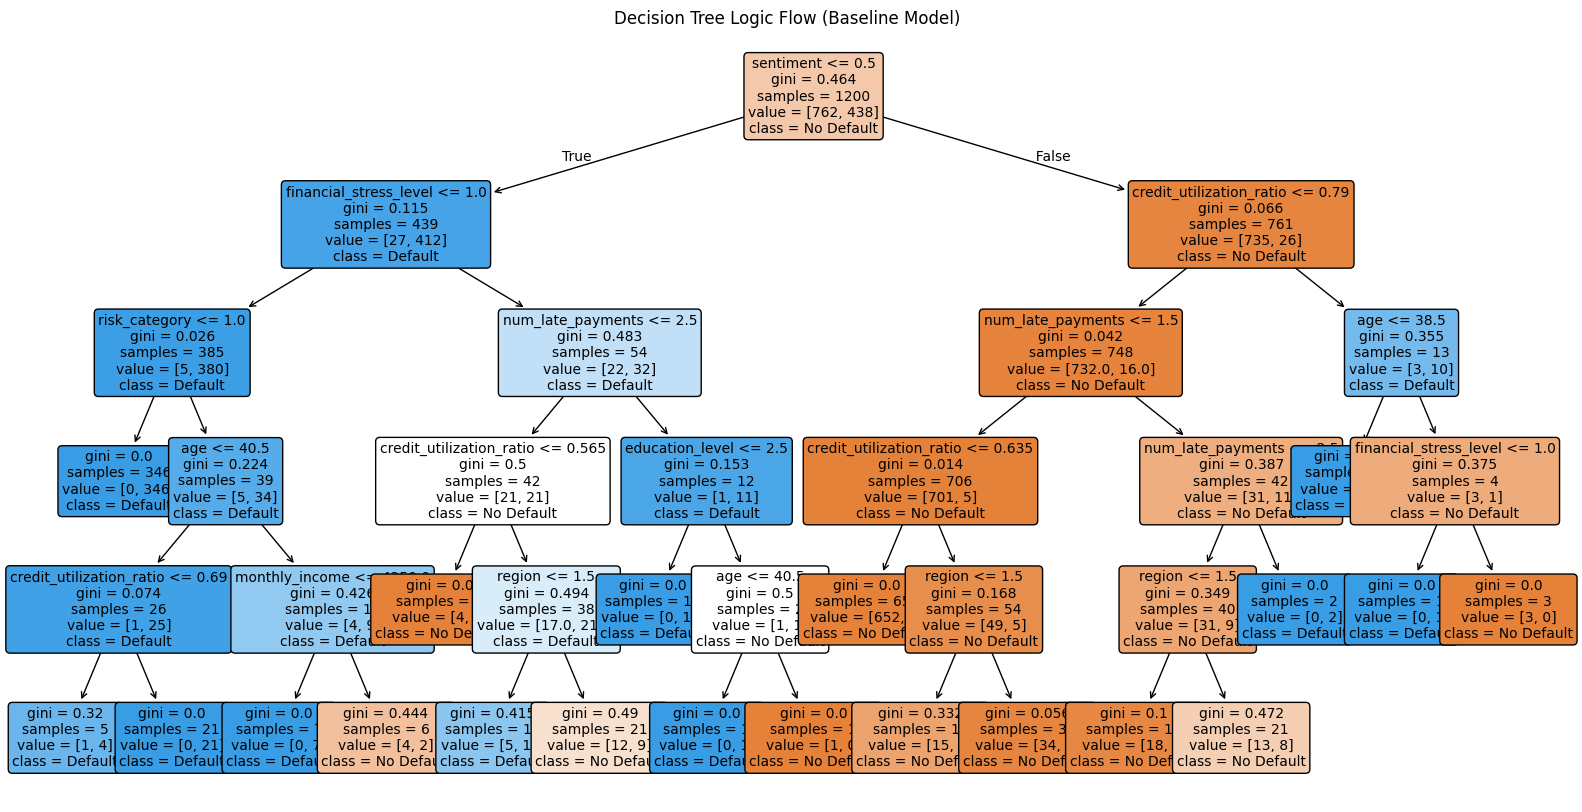


--- GENAI BASELINE INTERPRETATION ---
As a Senior Risk Data Scientist, I've reviewed the baseline Decision Tree model's performance and feature contributions.

---

### **1. Evaluation of Baseline Performance Acceptability**

The baseline model demonstrates **exceptionally strong performance** across all provided metrics:

*   **Accuracy (0.947):** Very high, indicating the model correctly classifies a large proportion of cases.
*   **F1_Score (0.924):** Excellent, showing a robust balance between precision and recall, which is crucial for imbalanced credit risk datasets where identifying true defaults (recall) without excessive false positives (precision) is key.
*   **ROC_AUC (0.985):** Outstanding. An AUC value this close to 1 signifies near-perfect discriminative power, meaning the model is extremely effective at distinguishing between high-risk and low-risk individuals across various classification thresholds.

**Conclusion on Acceptability:** This baseline performance is **more 

In [5]:
# 1. Initialize and Run Baseline
dt_baseline = DecisionTreeBaseline("./data/credit_risk_dataset.csv")
X_test, y_test, y_pred = dt_baseline.train_and_evaluate()

# 2. Print Metrics
print("--- BASELINE DECISION TREE METRICS ---")
for k, v in dt_baseline.metrics.items():
    print(f"{k}: {v:.4f}")

# 3. Visualize the Decision Tree (Visual Evidence for Report)
plt.figure(figsize=(20, 10))
plot_tree(dt_baseline.model, 
          feature_names=dt_baseline.X_train_cols, 
          class_names=['No Default', 'Default'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Logic Flow (Baseline Model)")
plt.show()

# 4. Get GenAI Interpretation (Task 3)
print("\n--- GENAI BASELINE INTERPRETATION ---")
baseline_insights = dt_baseline.get_llm_interpretation()
print(baseline_insights)